## Machine Learning and Artificial Intelligence 
Summer High School Academic Program for Engineers (2025)
## Convolutional Neural Networks and Computer Vision

###### Image Classification and the Cifar datasets

We will work on an an image classification task: Given an image (provided in the matplotlib format you are already familiar with), your goal is to identify the central object depicted, choosing from a set of possible object labels.

The Cifar dataset contains 60000 images at 32x32 resolution with 3 color channels, each with a label. Labels are available in coarse form (Cifar10 - 10 total labels) and more fine-grained form (Cifar100 - 100 total labels).

In [2]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

# Load data -- adjust the path as needed
train_dict = unpickle('cifar-100-python/train')
test_dict = unpickle('cifar-100-python/test')

# Extract images and labels
X_train = train_dict['data']  # shape: (50000, 3072)
y_train = train_dict['fine_labels']  # or 'coarse_labels'

X_test = test_dict['data']
y_test = test_dict['fine_labels']

In [3]:
train_dict['data'][0].shape

(3072,)

In [4]:
meta = unpickle('cifar-100-python/meta')
label_names = meta['fine_label_names']  # List of 100 class names

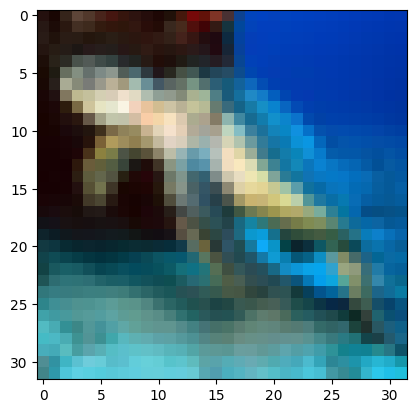

In [5]:
plt.imshow(train_dict['data'][99].reshape(3,32,32).transpose((1,2,0)))

In [6]:
label_names[train_dict['fine_labels'][99]]

'turtle'

Note that image data is very different from the sort of tabular data we worked with so far. In tabular data, relevant feature have already been extracted through **manual feature engineering**. In image data (and text data -- see next week), we do not have an explicit set of features and we use neural networks to automaticically extract features. This is known as **representation learning**.

Let's say we want to train a standard feed forward neural network to classify these images. Each image has 32*32=1024 pixels. There are three color channels, so we get (3,32,32) tensors representing each image -- a total of 3072 input units. 

Every unit in the first hidden layer will have to be connected to each of these input units. A single hidden layer of size 100 would therefore need 10*3072 = 307,200 parameters!

CNNs offer a solution to this problem by learning to transform images into lower-dimensional representations that retain relevant information for classification. In CNN vision models, images are represented as a combination of increasingly abstract features that may appear in different local regions. 

<img src="https://www.cs.columbia.edu/~bauer/shape/cnn_feature_hierarchy.png" width=600px>

When building a feed-forward network for MNIST, you may have realized that the number of parameters quickly becomes very large. You could train such a model on modern GPUs. Historically, one of the first CNNs was LeNet5 (LeCun et al, 1998), which was applied to MNIST. At that time, GPUs didn't exist and automatic feature extraction was a novel idea.

### Convolution in 1D

Assume we have an input sequence such as the following (maybe a time series, such as a sequence of daily stock prices). This is different from the sort of tabular feature-based representations we have seen so far.  

In [302]:
x = torch.tensor([4, 5, 1, 6, 8]) # size 5

Assume we create a feed-forward layer of size (4,). This would require a (5x4) weight matrix, that is 20 total parameters (plus the bias).

Now assume instead that we have a "**kernel**" (also called a **filter**), which is a matrix of size (2,). 

In [305]:
kernel = torch.tensor([-1,1])

We now slide the kernel over the input, computing a dot product in each step. 

In [308]:
x[0:2] @ kernel   # [4,5] @ [-1,1]^T = 4*-1 + 5*1 = 1 

tensor(1)

In [310]:
x[1:3] @ kernel # [5,1] @ [-1, 1]^T = 5*-1 + 1*1 = -4

tensor(-4)

In [312]:
x[2:4] @ kernel

tensor(5)

In [314]:
x[3:5] @ kernel

tensor(2)

We then put the results back into a vector

In [324]:
output = torch.tensor([x[i:i+2] @ kernel for i in range(len(x)-1)])
output

tensor([ 1, -4,  5,  2])

This operation is called a **convolution** of the input (side note: in mathematical terms this operation is more correctly called cross-correlation, but in ML people use the term convolution). The output is often called a **feature map**.

The idea is that the kernel can pick up occurences of a certain pattern/feature in the input. In this example, the feature will match any region of the input that show large changes between consecutive values: -4 indicates a steep drop from 5 to 1, while 5 indicates an indcrease from 1 to 6. 

The result is a size (5,) representation of the input that can be used, for example, for a classification task (for instance, maybe many sharp changes suggest volatility and thus indicate that we should sell the stock). The kernel is a weight vector that is learned while we train the model on the classification task. 

Note that convolution requires far fewer parameters, i.e. the size of the filter(2 features instead of 20!). It does however make an assumption that a good representation for the object can be obtained from the local features. 

In an actual implementation, the filter does not actually "slide" the filter over the input step by step. Instead, the filter is applied to all input positions simultaneously using batching, so this operation can be parallelized on a GPU. There really are only 2 weights and they are shared between all the input positions. 

### 2D Convolution Applied to Images

Recall that we can represent an images as a (width,height,color_channels) tensor. 

<img src="http://www.cs.columbia.edu/~bauer/shape/image_representation.png" width=300px>

#### Convolution on a single 2D Matrix

Let's consider a single color channel first. We can define a filter in 2D. 

<img src="https://www.cs.columbia.edu/~bauer/shape/kernel_illustration1.png" width="300px"> <img src="https://www.cs.columbia.edu/~bauer/shape/kernel_illustration2.png" width="300px">

As before, the filter is applied to all possible positions in the image. For each position we calculate the kernel activation as the weighted sum between the entries in the two matrices. For example, for the upper left position: $1 \cdot 234 + 0 \cdot 0 + 0 \cdot 0 + 2\cdot 230 = 694$. For the second position (left corner of the kernel matches row 1 column 2 of the input matrix): $1 \cdot 0 + 0 \cdot 0 + 0 \cdot 230 + 2 \cdot 7 = 140$

There are 3x3=9 positions, so the resulting feature map is 

In [293]:
torch.tensor([[694, 140,   0],
              [  4, 684,  70],
              [  4,   8, 517]])

tensor([[694, 140,   0],
        [  4, 684,  70],
        [  4,   8, 517]])

**Stride and Padding**

When defining a convolution operation we can specify the stride and padding. 

**Stride** is the number of indices that the kernel "slides" in each step. In the example above, the stride is 1. If we set stride = 2, we move the kernel by 2 positions instead, skipping every other position.

<img src="https://www.cs.columbia.edu/~bauer/shape/kernel_illustration3.png" width="400px"> 

Increasing the stride will result in future entries in the feature map. With stride=2, the feature map on a (4,4) matrix will be (2,2).

In [353]:
torch.tensor([[694,0], 
              [4,517]])

tensor([[694,   0],
        [  4, 517]])

**Padding** Padding allows the kernel to reach beyond the boundaries of the input matrix. Typically the matrix is padded with 0. 
<img src="https://www.cs.columbia.edu/~bauer/shape/kernel_illustration4.png" width="350px"> 

With padding, the size of the feature map is identical to the size of the input matrix.


#### Multiple Kernels

We often apply multiple kernels at the same time, and then stack the resulting feature maps together into a 3D tensor. The idea is that each kernel will learn to focus on a different feature of the image. The different kernels are called "out channels" in pyTorch and the number of kernels is sometimes referred to as the "depth".

<img src="https://www.cs.columbia.edu/~bauer/shape/kernel_illustration5.png" width="400px"> 



In the example, we have two kernels:

In [458]:
torch.tensor([[[1,0],[0,2]],[[0,3],[-1,0]]], dtype=torch.float)

tensor([[[ 1.,  0.],
         [ 0.,  2.]],

        [[ 0.,  3.],
         [-1.,  0.]]])

The input matrix is:

In [455]:
torch.tensor([[234,0,0,0],[0,230,70,0],[0,2,227,0],[0,2,3,145]], dtype=torch.float)

tensor([[234.,   0.,   0.,   0.],
        [  0., 230.,  70.,   0.],
        [  0.,   2., 227.,   0.],
        [  0.,   2.,   3., 145.]])

Applying both kernels results in the tensor: 

In [453]:
torch.tensor([[[694., 140.,   0.],
               [  4., 684.,  70.],
               [  4.,   8., 517.]],

               [[   0., -230.,  -70.],
                [ 690.,  208., -227.],
                [  6.,  679.,   -3.]]])

tensor([[[ 694.,  140.,    0.],
         [   4.,  684.,   70.],
         [   4.,    8.,  517.]],

        [[   0., -230.,  -70.],
         [ 690.,  208., -227.],
         [   6.,  679.,   -3.]]])

Each kernel represents an abstract features, and the feature maps measure to what degree each feature appears in different local regions of the image. Visualizing the feature maps makes this intuition clear. 

<img src="https://www.cs.columbia.edu/~bauer/shape/feature_map_visualization.png" width="500px"> 

#### Multiple Input Channels

If we are working on images, we have 3 color channels (RGB). Similarly, if we have multiple convolution layers in a neural network, then subsequent layers will need to process the multiple "out channels" from the previous layer. 

Assume we just have a single kernel and three input channels. The kernel is applied to each channel individually, resulting in three different feature maps. Then, the resulting maps are summed pointwise, resulting in a single feature map. 

<img src="https://www.cs.columbia.edu/~bauer/shape/kernel_illustration6.png" width="500px"> 


### Pooling

Pooling reduces the dimensionality of a feature map (or stack of feature maps). The goal is to reduce the number of parameters, while maintainign the most relevant information in the feature map. In addition to saving memory it may also help prevent overfitting by generalizing over small differences in the image.

Pooling is essentially a down-sampling method. We divide the feature map up into smaller (typically square) windows which may or may not overlap. As in convolution, this can be controlled using the stride parameter. Each of these sections results in a single value. We can either take the max value in the section (**max pooling**) or average the values (**value pooling**). 

For example, max pooling on a (4,4) feature map with window size 2x2 and stride 2 might look like this: 

<img src="https://www.cs.columbia.edu/~bauer/shape/pooling.png" width="500px"> 

### Convolutional Neural Networks

CNN vision models use Convolution and Pooling to learn increasingly abstract feature representations of an input image. Here is a (very basic) CNN vision model for the Cifar-10 task: 

<img src="https://www.cs.columbia.edu/~bauer/shape/cnn_architecture.png" width="600px">